## Method Overview

1. Model = ResNet-101
2. Input size = 256
3. Train/Val split = 80:20
4. Best Accuracy Validation = 84%
5. Loss function = Cross Entropy Loss
6. Optimizer = Adam Optimzer

## Alternative Method 

1. I think using Segmentation networks like Mask-Rcnn, FCN we can segment more distinctive features to get better accuracy.
(In e-mail, I was asked to complete as soon as possible so I went with Classification Algorithms).

In [1]:
# Importing libraries

import torch
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.image as mpimg
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import numpy as np
from sklearn.metrics import classification_report
from tqdm import tqdm_notebook
target_names = ['class 1', 'class 2']
import os
import cv2
import glob
import warnings
import time
warnings.filterwarnings('ignore')

In [2]:
# Defining classes and image size

num_classes = 2
batch_size = 24
input_size = (256, 256)

data_dir = '/home/karan/python/pytorch/ChinaSet_AllFiles/ChinaSet_AllFiles/'

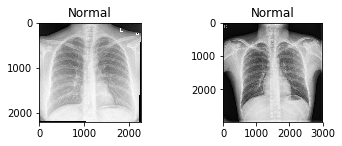

In [69]:
# Exploratory Data Analysis for normal images

fig = plt.figure()

for i, j in zip(glob.glob(data_dir + '/train/0/*.png'), range(2)):
    img1 = cv2.imread(i)
    ax1 = fig.add_subplot(2,2,j+1)
    ax1.imshow(img1)
    ax1.set_title('Normal')

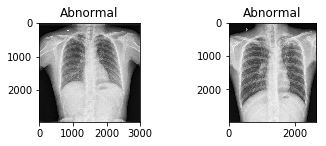

In [73]:
# Abnormal images

fig = plt.figure()

for i, j in zip(glob.glob(data_dir + '/train/1/*.png'), range(2)):
    img1 = cv2.imread(i)
    ax1 = fig.add_subplot(2,2,j+1)
    ax1.imshow(img1)
    ax1.set_title('Abnormal')

### Length of Both classes

In [48]:
print('Length of Training Dataset:')
print('Length of Normal Images :', len(os.listdir(data_dir+'/train/0/')))
print('Length of Abnormal Images :', len(os.listdir(data_dir+'/train/1/')))
print('Length of Validation Dataset:')
print('Length of Normal Images :', len(os.listdir(data_dir+'/val/0/')))
print('Length of Abnormal Images :', len(os.listdir(data_dir+'/val/1/')))


Length of Training Dataset:
Length of Normal Images : 262
Length of Abnormal Images : 268
Length of Validation Dataset:
Length of Normal Images : 64
Length of Abnormal Images : 68


In [3]:
# Data Augmentation for getting generalized model and learning more distinctive features.

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomAffine(60),
        transforms.CenterCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Create training and validation datasets

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create training and validation dataloaders

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
# A function that takes model and hyper parameters and saves best validation accuracy

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        class1 = 0
        class2 = 0

        class11 = 0
        class22 = 0
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm_notebook(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    if phase == 'train':
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()  
                        
                    if phase == 'val':
                           
                        predictions = preds.cpu().numpy()
                        lb = labels.cpu().numpy()

                        for i in range(len(lb)):
                            if lb[i] == 0:
                                class1 += 1
                                if predictions[i] == lb[i]:
                                    class11 += 1
                            elif lb[i] == 1:
                                class2 += 1
                                if predictions[i] == lb[i]:
                                    class22 += 1
 
                                                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))  
            
            if phase == 'val':
                print('Validation Accuracy:')
                print('Class 1: Total Correct: %d Total Count: %d Accuracy: %.3f' % (class11, class1, class11/class1))
                print('Class 2: Total Correct: %d Total Count: %d Accuracy: %.3f' % (class22, class2, class22/class2))
                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
                torch.save(state, 'best_model.pth')

            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(state['state_dict'])

    return model, val_acc_history

In [5]:
# Defining model

model_ft = models.resnet101(pretrained=True)

# Changing last FC

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

# Loss function

criterion = nn.CrossEntropyLoss()

# Optimizer and lr decay

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

In [27]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200)

Epoch 0/199
----------



train Loss: 1.0818 Acc: 0.5170



val Loss: 277339.7784 Acc: 0.4848
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 0 Total Count: 68 Accuracy: 0.000

Epoch 1/199
----------



train Loss: 0.7744 Acc: 0.4566



val Loss: 0.6954 Acc: 0.4848
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 0 Total Count: 68 Accuracy: 0.000

Epoch 2/199
----------



train Loss: 0.7618 Acc: 0.5283



val Loss: 53.4158 Acc: 0.5152
Validation Accuracy:
Class 1: Total Correct: 63 Total Count: 64 Accuracy: 0.984
Class 2: Total Correct: 5 Total Count: 68 Accuracy: 0.074

Epoch 3/199
----------



train Loss: 0.6596 Acc: 0.5660



val Loss: 1.1131 Acc: 0.5227
Validation Accuracy:
Class 1: Total Correct: 1 Total Count: 64 Accuracy: 0.016
Class 2: Total Correct: 68 Total Count: 68 Accuracy: 1.000

Epoch 4/199
----------



train Loss: 0.6292 Acc: 0.6906



val Loss: 0.7945 Acc: 0.8030
Validation Accuracy:
Class 1: Total Correct: 54 Total Count: 64 Accuracy: 0.844
Class 2: Total Correct: 52 Total Count: 68 Accuracy: 0.765

Epoch 5/199
----------



train Loss: 0.5877 Acc: 0.7019



val Loss: 50.2532 Acc: 0.5833
Validation Accuracy:
Class 1: Total Correct: 63 Total Count: 64 Accuracy: 0.984
Class 2: Total Correct: 14 Total Count: 68 Accuracy: 0.206

Epoch 6/199
----------



train Loss: 0.6238 Acc: 0.7132



val Loss: 0.9896 Acc: 0.4318
Validation Accuracy:
Class 1: Total Correct: 54 Total Count: 64 Accuracy: 0.844
Class 2: Total Correct: 3 Total Count: 68 Accuracy: 0.044

Epoch 7/199
----------



train Loss: 0.5634 Acc: 0.7264



val Loss: 0.4942 Acc: 0.8106
Validation Accuracy:
Class 1: Total Correct: 62 Total Count: 64 Accuracy: 0.969
Class 2: Total Correct: 45 Total Count: 68 Accuracy: 0.662

Epoch 8/199
----------



train Loss: 0.5392 Acc: 0.7472



val Loss: 0.5544 Acc: 0.8182
Validation Accuracy:
Class 1: Total Correct: 62 Total Count: 64 Accuracy: 0.969
Class 2: Total Correct: 46 Total Count: 68 Accuracy: 0.676

Epoch 9/199
----------



train Loss: 0.5212 Acc: 0.7585



val Loss: 0.4637 Acc: 0.8333
Validation Accuracy:
Class 1: Total Correct: 62 Total Count: 64 Accuracy: 0.969
Class 2: Total Correct: 48 Total Count: 68 Accuracy: 0.706

Epoch 10/199
----------



train Loss: 0.5303 Acc: 0.7566



val Loss: 0.4795 Acc: 0.8182
Validation Accuracy:
Class 1: Total Correct: 62 Total Count: 64 Accuracy: 0.969
Class 2: Total Correct: 46 Total Count: 68 Accuracy: 0.676

Epoch 11/199
----------



train Loss: 0.5274 Acc: 0.7509



val Loss: 0.6635 Acc: 0.6212
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 18 Total Count: 68 Accuracy: 0.265

Epoch 12/199
----------



train Loss: 0.5185 Acc: 0.7604



val Loss: 0.6081 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 13/199
----------



train Loss: 0.5140 Acc: 0.7698



val Loss: 0.6756 Acc: 0.6136
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 17 Total Count: 68 Accuracy: 0.250

Epoch 14/199
----------



train Loss: 0.5261 Acc: 0.7604



val Loss: 0.5455 Acc: 0.7348
Validation Accuracy:
Class 1: Total Correct: 63 Total Count: 64 Accuracy: 0.984
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 15/199
----------



train Loss: 0.5129 Acc: 0.7717



val Loss: 0.5278 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 62 Total Count: 64 Accuracy: 0.969
Class 2: Total Correct: 36 Total Count: 68 Accuracy: 0.529

Epoch 16/199
----------



train Loss: 0.5116 Acc: 0.7623



val Loss: 0.5377 Acc: 0.7500
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 35 Total Count: 68 Accuracy: 0.515

Epoch 17/199
----------



train Loss: 0.5003 Acc: 0.7792



val Loss: 0.5468 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 18/199
----------



train Loss: 0.4970 Acc: 0.7736



val Loss: 0.5863 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 19/199
----------



train Loss: 0.4967 Acc: 0.7528



val Loss: 0.5595 Acc: 0.7273
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 32 Total Count: 68 Accuracy: 0.471

Epoch 20/199
----------



train Loss: 0.4978 Acc: 0.7698



val Loss: 0.5583 Acc: 0.7197
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 31 Total Count: 68 Accuracy: 0.456

Epoch 21/199
----------



train Loss: 0.4988 Acc: 0.7660



val Loss: 0.5641 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 22/199
----------



train Loss: 0.5047 Acc: 0.7868



val Loss: 0.5417 Acc: 0.7500
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 35 Total Count: 68 Accuracy: 0.515

Epoch 23/199
----------



train Loss: 0.5042 Acc: 0.7660



val Loss: 0.5360 Acc: 0.7576
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 36 Total Count: 68 Accuracy: 0.529

Epoch 24/199
----------



train Loss: 0.5043 Acc: 0.7792



val Loss: 0.5423 Acc: 0.7500
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 35 Total Count: 68 Accuracy: 0.515

Epoch 25/199
----------



train Loss: 0.5015 Acc: 0.7792



val Loss: 0.5513 Acc: 0.7500
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 35 Total Count: 68 Accuracy: 0.515

Epoch 26/199
----------



train Loss: 0.5005 Acc: 0.7623



val Loss: 0.5632 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 27/199
----------



train Loss: 0.4992 Acc: 0.7679



val Loss: 0.5529 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 28/199
----------



train Loss: 0.5075 Acc: 0.7679



val Loss: 0.5929 Acc: 0.6667
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 24 Total Count: 68 Accuracy: 0.353

Epoch 29/199
----------



train Loss: 0.4938 Acc: 0.7642



val Loss: 0.5857 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 30/199
----------



train Loss: 0.4947 Acc: 0.7774



val Loss: 0.5522 Acc: 0.7348
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 33 Total Count: 68 Accuracy: 0.485

Epoch 31/199
----------



train Loss: 0.4952 Acc: 0.7755



val Loss: 0.5545 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 32/199
----------



train Loss: 0.5097 Acc: 0.7547



val Loss: 0.5919 Acc: 0.6894
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 27 Total Count: 68 Accuracy: 0.397

Epoch 33/199
----------



train Loss: 0.4967 Acc: 0.7736



val Loss: 0.5910 Acc: 0.6818
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 26 Total Count: 68 Accuracy: 0.382

Epoch 34/199
----------



train Loss: 0.4959 Acc: 0.7774



val Loss: 0.5791 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 35/199
----------



train Loss: 0.5001 Acc: 0.7736



val Loss: 0.5807 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 36/199
----------



train Loss: 0.4987 Acc: 0.7717



val Loss: 0.5786 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 37/199
----------



train Loss: 0.5014 Acc: 0.7849



val Loss: 0.5724 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 38/199
----------



train Loss: 0.5004 Acc: 0.7698



val Loss: 0.5425 Acc: 0.7500
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 35 Total Count: 68 Accuracy: 0.515

Epoch 39/199
----------



train Loss: 0.4907 Acc: 0.7774



val Loss: 0.5676 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 40/199
----------



train Loss: 0.5069 Acc: 0.7566



val Loss: 0.5576 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 41/199
----------



train Loss: 0.4959 Acc: 0.7698



val Loss: 0.5825 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 42/199
----------



train Loss: 0.5079 Acc: 0.7679



val Loss: 0.5772 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 43/199
----------



train Loss: 0.5018 Acc: 0.7736



val Loss: 0.5742 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 44/199
----------



train Loss: 0.4990 Acc: 0.7679



val Loss: 0.5321 Acc: 0.7576
Validation Accuracy:
Class 1: Total Correct: 63 Total Count: 64 Accuracy: 0.984
Class 2: Total Correct: 37 Total Count: 68 Accuracy: 0.544

Epoch 45/199
----------



train Loss: 0.5103 Acc: 0.7585



val Loss: 0.5633 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 46/199
----------



train Loss: 0.5030 Acc: 0.7698



val Loss: 0.5813 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 47/199
----------



train Loss: 0.4942 Acc: 0.7755



val Loss: 0.5708 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 48/199
----------



train Loss: 0.4912 Acc: 0.7642



val Loss: 0.5997 Acc: 0.6894
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 27 Total Count: 68 Accuracy: 0.397

Epoch 49/199
----------



train Loss: 0.4887 Acc: 0.7849



val Loss: 0.5631 Acc: 0.7197
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 31 Total Count: 68 Accuracy: 0.456

Epoch 50/199
----------



train Loss: 0.4832 Acc: 0.8038



val Loss: 0.5771 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 51/199
----------



train Loss: 0.4957 Acc: 0.7660



val Loss: 0.5524 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 52/199
----------



train Loss: 0.5073 Acc: 0.7755



val Loss: 0.5679 Acc: 0.7197
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 31 Total Count: 68 Accuracy: 0.456

Epoch 53/199
----------



train Loss: 0.4874 Acc: 0.7811



val Loss: 0.5647 Acc: 0.7197
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 31 Total Count: 68 Accuracy: 0.456

Epoch 54/199
----------



train Loss: 0.4937 Acc: 0.7792



val Loss: 0.5779 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 55/199
----------



train Loss: 0.4924 Acc: 0.7811



val Loss: 0.5680 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 56/199
----------



train Loss: 0.4869 Acc: 0.7849



val Loss: 0.5865 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 57/199
----------



train Loss: 0.5034 Acc: 0.7717



val Loss: 0.6012 Acc: 0.6742
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 25 Total Count: 68 Accuracy: 0.368

Epoch 58/199
----------



train Loss: 0.5045 Acc: 0.7736



val Loss: 0.5922 Acc: 0.6818
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 26 Total Count: 68 Accuracy: 0.382

Epoch 59/199
----------



train Loss: 0.4981 Acc: 0.7717



val Loss: 0.5803 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 60/199
----------



train Loss: 0.4968 Acc: 0.7811



val Loss: 0.5899 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 61/199
----------



train Loss: 0.5007 Acc: 0.7585



val Loss: 0.5978 Acc: 0.6818
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 26 Total Count: 68 Accuracy: 0.382

Epoch 62/199
----------



train Loss: 0.5014 Acc: 0.7623



val Loss: 0.6002 Acc: 0.6667
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 24 Total Count: 68 Accuracy: 0.353

Epoch 63/199
----------



train Loss: 0.5109 Acc: 0.7698



val Loss: 0.5790 Acc: 0.6894
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 27 Total Count: 68 Accuracy: 0.397

Epoch 64/199
----------



train Loss: 0.5022 Acc: 0.7736



val Loss: 0.5663 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 65/199
----------



train Loss: 0.4976 Acc: 0.7679



val Loss: 0.5460 Acc: 0.7500
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 35 Total Count: 68 Accuracy: 0.515

Epoch 66/199
----------



train Loss: 0.4926 Acc: 0.7755



val Loss: 0.5849 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 67/199
----------



train Loss: 0.4876 Acc: 0.7887



val Loss: 0.5837 Acc: 0.6894
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 27 Total Count: 68 Accuracy: 0.397

Epoch 68/199
----------



train Loss: 0.5010 Acc: 0.7774



val Loss: 0.5804 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 69/199
----------



train Loss: 0.4882 Acc: 0.7792



val Loss: 0.5767 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 70/199
----------



train Loss: 0.4894 Acc: 0.7774



val Loss: 0.5752 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 71/199
----------



train Loss: 0.5060 Acc: 0.7679



val Loss: 0.5730 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 72/199
----------



train Loss: 0.4933 Acc: 0.7868



val Loss: 0.5870 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 73/199
----------



train Loss: 0.5038 Acc: 0.7547



val Loss: 0.5482 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 74/199
----------



train Loss: 0.4962 Acc: 0.7774



val Loss: 0.5582 Acc: 0.7348
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 33 Total Count: 68 Accuracy: 0.485

Epoch 75/199
----------



train Loss: 0.5029 Acc: 0.7849



val Loss: 0.5913 Acc: 0.6894
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 27 Total Count: 68 Accuracy: 0.397

Epoch 76/199
----------



train Loss: 0.5014 Acc: 0.7736



val Loss: 0.5904 Acc: 0.6894
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 27 Total Count: 68 Accuracy: 0.397

Epoch 77/199
----------



train Loss: 0.4952 Acc: 0.7868



val Loss: 0.5833 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 78/199
----------



train Loss: 0.5043 Acc: 0.7679



val Loss: 0.6190 Acc: 0.6667
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 24 Total Count: 68 Accuracy: 0.353

Epoch 79/199
----------



train Loss: 0.5045 Acc: 0.7736



val Loss: 0.5702 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 80/199
----------



train Loss: 0.4974 Acc: 0.7811



val Loss: 0.5667 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 81/199
----------



train Loss: 0.4972 Acc: 0.7755



val Loss: 0.5863 Acc: 0.6742
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 25 Total Count: 68 Accuracy: 0.368

Epoch 82/199
----------



train Loss: 0.4947 Acc: 0.7717



val Loss: 0.5641 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 83/199
----------



train Loss: 0.4956 Acc: 0.7868



val Loss: 0.5670 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 84/199
----------



train Loss: 0.4948 Acc: 0.7717



val Loss: 0.5434 Acc: 0.7500
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 35 Total Count: 68 Accuracy: 0.515

Epoch 85/199
----------



train Loss: 0.5142 Acc: 0.7811



val Loss: 0.5631 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 86/199
----------



train Loss: 0.4897 Acc: 0.7660



val Loss: 0.5819 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 87/199
----------



train Loss: 0.4906 Acc: 0.7736



val Loss: 0.5815 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 88/199
----------



train Loss: 0.5005 Acc: 0.7642



val Loss: 0.5696 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 89/199
----------



train Loss: 0.5051 Acc: 0.7736



val Loss: 0.5598 Acc: 0.7273
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 32 Total Count: 68 Accuracy: 0.471

Epoch 90/199
----------



train Loss: 0.5056 Acc: 0.7604



val Loss: 0.6039 Acc: 0.6667
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 24 Total Count: 68 Accuracy: 0.353

Epoch 91/199
----------



train Loss: 0.4905 Acc: 0.7830



val Loss: 0.5721 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 92/199
----------



train Loss: 0.4913 Acc: 0.7774



val Loss: 0.5652 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 93/199
----------



train Loss: 0.5170 Acc: 0.7698



val Loss: 0.5798 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 94/199
----------



train Loss: 0.4928 Acc: 0.7736



val Loss: 0.5915 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 95/199
----------



train Loss: 0.4875 Acc: 0.7717



val Loss: 0.5959 Acc: 0.6742
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 25 Total Count: 68 Accuracy: 0.368

Epoch 96/199
----------



train Loss: 0.4941 Acc: 0.7925



val Loss: 0.5645 Acc: 0.7197
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 31 Total Count: 68 Accuracy: 0.456

Epoch 97/199
----------



train Loss: 0.4970 Acc: 0.7585



val Loss: 0.5433 Acc: 0.7500
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 35 Total Count: 68 Accuracy: 0.515

Epoch 98/199
----------



train Loss: 0.4953 Acc: 0.7717



val Loss: 0.5668 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 99/199
----------



train Loss: 0.4933 Acc: 0.7868



val Loss: 0.5754 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 100/199
----------



train Loss: 0.4935 Acc: 0.7698



val Loss: 0.5804 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 101/199
----------



train Loss: 0.4883 Acc: 0.7887



val Loss: 0.5891 Acc: 0.6894
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 27 Total Count: 68 Accuracy: 0.397

Epoch 102/199
----------



train Loss: 0.4990 Acc: 0.7717



val Loss: 0.5432 Acc: 0.7500
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 35 Total Count: 68 Accuracy: 0.515

Epoch 103/199
----------



train Loss: 0.4988 Acc: 0.7604



val Loss: 0.5711 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 104/199
----------



train Loss: 0.4955 Acc: 0.7736



val Loss: 0.5399 Acc: 0.7652
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 37 Total Count: 68 Accuracy: 0.544

Epoch 105/199
----------



train Loss: 0.4958 Acc: 0.7642



val Loss: 0.5832 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 106/199
----------



train Loss: 0.4994 Acc: 0.7830



val Loss: 0.5594 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 107/199
----------



train Loss: 0.5000 Acc: 0.7660



val Loss: 0.5494 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 108/199
----------



train Loss: 0.4824 Acc: 0.7811



val Loss: 0.5821 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 109/199
----------



train Loss: 0.4997 Acc: 0.7623



val Loss: 0.5705 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 110/199
----------



train Loss: 0.5001 Acc: 0.7660



val Loss: 0.6013 Acc: 0.6818
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 26 Total Count: 68 Accuracy: 0.382

Epoch 111/199
----------



train Loss: 0.4986 Acc: 0.7868



val Loss: 0.5881 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 112/199
----------



train Loss: 0.4994 Acc: 0.7868



val Loss: 0.5538 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 113/199
----------



train Loss: 0.4947 Acc: 0.7698



val Loss: 0.5931 Acc: 0.6818
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 26 Total Count: 68 Accuracy: 0.382

Epoch 114/199
----------



train Loss: 0.4901 Acc: 0.7774



val Loss: 0.5720 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 115/199
----------



train Loss: 0.5041 Acc: 0.7698



val Loss: 0.5648 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 116/199
----------



train Loss: 0.4895 Acc: 0.7736



val Loss: 0.5617 Acc: 0.7273
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 32 Total Count: 68 Accuracy: 0.471

Epoch 117/199
----------



train Loss: 0.4884 Acc: 0.7755



val Loss: 0.5609 Acc: 0.7273
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 32 Total Count: 68 Accuracy: 0.471

Epoch 118/199
----------



train Loss: 0.5015 Acc: 0.7623



val Loss: 0.5853 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 119/199
----------



train Loss: 0.4968 Acc: 0.7736



val Loss: 0.5776 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 120/199
----------



train Loss: 0.4778 Acc: 0.7868



val Loss: 0.5437 Acc: 0.7500
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 35 Total Count: 68 Accuracy: 0.515

Epoch 121/199
----------



train Loss: 0.4986 Acc: 0.7849



val Loss: 0.5692 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 122/199
----------



train Loss: 0.4932 Acc: 0.7792



val Loss: 0.5652 Acc: 0.7197
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 31 Total Count: 68 Accuracy: 0.456

Epoch 123/199
----------



train Loss: 0.4998 Acc: 0.7660



val Loss: 0.5713 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 124/199
----------



train Loss: 0.4937 Acc: 0.7887



val Loss: 0.5536 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 125/199
----------



train Loss: 0.4870 Acc: 0.7811



val Loss: 0.5725 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 126/199
----------



train Loss: 0.4920 Acc: 0.7755



val Loss: 0.5908 Acc: 0.6818
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 26 Total Count: 68 Accuracy: 0.382

Epoch 127/199
----------



train Loss: 0.5057 Acc: 0.7509



val Loss: 0.5620 Acc: 0.7273
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 32 Total Count: 68 Accuracy: 0.471

Epoch 128/199
----------



train Loss: 0.5035 Acc: 0.7585



val Loss: 0.5554 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 129/199
----------



train Loss: 0.4995 Acc: 0.7717



val Loss: 0.5684 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 130/199
----------



train Loss: 0.5006 Acc: 0.7792



val Loss: 0.5478 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 131/199
----------



train Loss: 0.5157 Acc: 0.7642



val Loss: 0.5590 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 132/199
----------



train Loss: 0.5011 Acc: 0.7736



val Loss: 0.5617 Acc: 0.7273
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 32 Total Count: 68 Accuracy: 0.471

Epoch 133/199
----------



train Loss: 0.5035 Acc: 0.7736



val Loss: 0.5407 Acc: 0.7576
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 36 Total Count: 68 Accuracy: 0.529

Epoch 134/199
----------



train Loss: 0.5021 Acc: 0.7623



val Loss: 0.5687 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 135/199
----------



train Loss: 0.5065 Acc: 0.7736



val Loss: 0.5672 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 136/199
----------



train Loss: 0.4908 Acc: 0.7679



val Loss: 0.5887 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 137/199
----------



train Loss: 0.4961 Acc: 0.7717



val Loss: 0.5658 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 138/199
----------



train Loss: 0.5006 Acc: 0.7698



val Loss: 0.5780 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 139/199
----------



train Loss: 0.4979 Acc: 0.7736



val Loss: 0.5823 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 140/199
----------



train Loss: 0.4986 Acc: 0.7509



val Loss: 0.5797 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 141/199
----------



train Loss: 0.5195 Acc: 0.7698



val Loss: 0.5467 Acc: 0.7500
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 35 Total Count: 68 Accuracy: 0.515

Epoch 142/199
----------



train Loss: 0.5095 Acc: 0.7642



val Loss: 0.5705 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 143/199
----------



train Loss: 0.5092 Acc: 0.7509



val Loss: 0.5837 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 144/199
----------



train Loss: 0.4995 Acc: 0.7679



val Loss: 0.5743 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 145/199
----------



train Loss: 0.5014 Acc: 0.7736



val Loss: 0.5543 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 146/199
----------



train Loss: 0.4917 Acc: 0.7717



val Loss: 0.5378 Acc: 0.7652
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 37 Total Count: 68 Accuracy: 0.544

Epoch 147/199
----------



train Loss: 0.5067 Acc: 0.7774



val Loss: 0.5825 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 148/199
----------



train Loss: 0.4895 Acc: 0.7849



val Loss: 0.5510 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 149/199
----------



train Loss: 0.4843 Acc: 0.7830



val Loss: 0.5709 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 150/199
----------



train Loss: 0.4955 Acc: 0.7736



val Loss: 0.5491 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 151/199
----------



train Loss: 0.4979 Acc: 0.7830



val Loss: 0.5553 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 152/199
----------



train Loss: 0.5043 Acc: 0.7755



val Loss: 0.5864 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 153/199
----------



train Loss: 0.4971 Acc: 0.7811



val Loss: 0.5916 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 154/199
----------



train Loss: 0.4898 Acc: 0.7792



val Loss: 0.5976 Acc: 0.6818
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 26 Total Count: 68 Accuracy: 0.382

Epoch 155/199
----------



train Loss: 0.4959 Acc: 0.7774



val Loss: 0.5750 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 156/199
----------



train Loss: 0.4916 Acc: 0.7830



val Loss: 0.5852 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 157/199
----------



train Loss: 0.5067 Acc: 0.7585



val Loss: 0.5485 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 158/199
----------



train Loss: 0.5089 Acc: 0.7604



val Loss: 0.5839 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 159/199
----------



train Loss: 0.4932 Acc: 0.7736



val Loss: 0.5803 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 160/199
----------



train Loss: 0.5017 Acc: 0.7736



val Loss: 0.5511 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 161/199
----------



train Loss: 0.5025 Acc: 0.7698



val Loss: 0.5674 Acc: 0.7197
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 31 Total Count: 68 Accuracy: 0.456

Epoch 162/199
----------



train Loss: 0.4970 Acc: 0.7698



val Loss: 0.5789 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 163/199
----------



train Loss: 0.4970 Acc: 0.7755



val Loss: 0.5439 Acc: 0.7576
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 36 Total Count: 68 Accuracy: 0.529

Epoch 164/199
----------



train Loss: 0.5102 Acc: 0.7849



val Loss: 0.5925 Acc: 0.6818
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 26 Total Count: 68 Accuracy: 0.382

Epoch 165/199
----------



train Loss: 0.4944 Acc: 0.7698



val Loss: 0.5635 Acc: 0.7197
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 31 Total Count: 68 Accuracy: 0.456

Epoch 166/199
----------



train Loss: 0.5101 Acc: 0.7585



val Loss: 0.5409 Acc: 0.7500
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 35 Total Count: 68 Accuracy: 0.515

Epoch 167/199
----------



train Loss: 0.4961 Acc: 0.7774



val Loss: 0.5470 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 168/199
----------



train Loss: 0.4865 Acc: 0.7811



val Loss: 0.5459 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 169/199
----------



train Loss: 0.4976 Acc: 0.7736



val Loss: 0.5381 Acc: 0.7576
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 36 Total Count: 68 Accuracy: 0.529

Epoch 170/199
----------



train Loss: 0.4881 Acc: 0.7811



val Loss: 0.5834 Acc: 0.6894
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 27 Total Count: 68 Accuracy: 0.397

Epoch 171/199
----------



train Loss: 0.4962 Acc: 0.7792



val Loss: 0.6064 Acc: 0.6667
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 24 Total Count: 68 Accuracy: 0.353

Epoch 172/199
----------



train Loss: 0.4981 Acc: 0.7717



val Loss: 0.5428 Acc: 0.7576
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 36 Total Count: 68 Accuracy: 0.529

Epoch 173/199
----------



train Loss: 0.4984 Acc: 0.7717



val Loss: 0.5662 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 174/199
----------



train Loss: 0.5070 Acc: 0.7604



val Loss: 0.5357 Acc: 0.7652
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 37 Total Count: 68 Accuracy: 0.544

Epoch 175/199
----------



train Loss: 0.5004 Acc: 0.7679



val Loss: 0.5645 Acc: 0.7197
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 31 Total Count: 68 Accuracy: 0.456

Epoch 176/199
----------



train Loss: 0.4986 Acc: 0.7717



val Loss: 0.5797 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 177/199
----------



train Loss: 0.5108 Acc: 0.7660



val Loss: 0.5864 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 178/199
----------



train Loss: 0.4860 Acc: 0.7943



val Loss: 0.5927 Acc: 0.6894
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 27 Total Count: 68 Accuracy: 0.397

Epoch 179/199
----------



train Loss: 0.4986 Acc: 0.7887



val Loss: 0.5574 Acc: 0.7348
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 33 Total Count: 68 Accuracy: 0.485

Epoch 180/199
----------



train Loss: 0.4897 Acc: 0.7660



val Loss: 0.5516 Acc: 0.7500
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 35 Total Count: 68 Accuracy: 0.515

Epoch 181/199
----------



train Loss: 0.5199 Acc: 0.7660



val Loss: 0.5765 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 182/199
----------



train Loss: 0.4940 Acc: 0.7774



val Loss: 0.5554 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 183/199
----------



train Loss: 0.5075 Acc: 0.7679



val Loss: 0.5754 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 184/199
----------



train Loss: 0.4874 Acc: 0.7868



val Loss: 0.5567 Acc: 0.7424
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 34 Total Count: 68 Accuracy: 0.500

Epoch 185/199
----------



train Loss: 0.4933 Acc: 0.7849



val Loss: 0.5647 Acc: 0.7273
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 32 Total Count: 68 Accuracy: 0.471

Epoch 186/199
----------



train Loss: 0.5023 Acc: 0.7698



val Loss: 0.5714 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 187/199
----------



train Loss: 0.4956 Acc: 0.7792



val Loss: 0.5827 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 188/199
----------



train Loss: 0.4994 Acc: 0.7792



val Loss: 0.5921 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 189/199
----------



train Loss: 0.4950 Acc: 0.7679



val Loss: 0.5584 Acc: 0.7348
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 33 Total Count: 68 Accuracy: 0.485

Epoch 190/199
----------



train Loss: 0.5008 Acc: 0.7660



val Loss: 0.5688 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 191/199
----------



train Loss: 0.4944 Acc: 0.7906



val Loss: 0.5758 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 192/199
----------



train Loss: 0.4944 Acc: 0.7566



val Loss: 0.5787 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 193/199
----------



train Loss: 0.4847 Acc: 0.7811



val Loss: 0.5804 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 194/199
----------



train Loss: 0.4982 Acc: 0.7698



val Loss: 0.5672 Acc: 0.7121
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 30 Total Count: 68 Accuracy: 0.441

Epoch 195/199
----------



train Loss: 0.4990 Acc: 0.7868



val Loss: 0.5743 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 196/199
----------



train Loss: 0.4931 Acc: 0.7774



val Loss: 0.5767 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 197/199
----------



train Loss: 0.4927 Acc: 0.7849



val Loss: 0.5781 Acc: 0.6970
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 28 Total Count: 68 Accuracy: 0.412

Epoch 198/199
----------



train Loss: 0.4991 Acc: 0.7736



val Loss: 0.5822 Acc: 0.7045
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 29 Total Count: 68 Accuracy: 0.426

Epoch 199/199
----------



train Loss: 0.4919 Acc: 0.7868



val Loss: 0.5913 Acc: 0.6818
Validation Accuracy:
Class 1: Total Correct: 64 Total Count: 64 Accuracy: 1.000
Class 2: Total Correct: 26 Total Count: 68 Accuracy: 0.382

Training complete in 80m 13s
Best val Acc: 0.833333


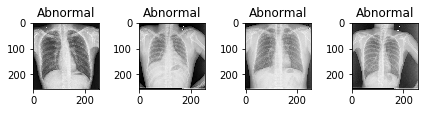

In [37]:
# Testing phase

for j, i in enumerate(glob.glob(data_dir+'/*.png')):
    img = cv2.imread(i)
    img = cv2.resize(img, (256,256))
    img1 = img
    img = torch.from_numpy(img)
    img = torch.tensor(img, dtype = torch.float32)
    img = img.view(1,3, 256, 256)
    outputs = model_ft(img.to(device))
    _, preds = torch.max(outputs, 1)
    plt.tight_layout()
    plt.subplot(2,4,j+1)

    if preds == 0:
        plt.title('Normal')
    else:
        plt.title('Abnormal')      
    plt.imshow(img1)

# Conclusions
Finally, the resnet model was able to classify the distinctive features of normal and abnormal tuberculosis images. Validation accuracy of 84% is a good measure to say that the resnet-101 model learned well to classify both classes.